### Simulating Interest Rate Changes and Liability Hedging
##### Implementing the Cox-Ingersoll-Roll Model, CIR, for Interest Rate
We saw in the previous section, when we look at the financial condition in terms of funding ratio, rather than asset value, even cash can be a risky asset.

We are going to simulate changes in interest rates using the CIR model. It is very similar to what we have already done for generating random stock prices. Instead of a Geometric Brownian Motion, the mean reversion model features parameters to control the speed of mean reversion as well as the long term average rate.
$$ dr_t = a(b - r_t)dt + \sigma\sqrt{r_t}dW_t $$ 
where
    - $a$: the speed of mean reversion
    - $b$: the long-term mean rate
    - $\sigma$: the volatility parameter

This can be read as describing the change in interest at any point of time as a multplie of the distance of the current rate from it's long-term mean plus a random value that depends on the volatility parameter.

Thus, we can start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the $\sqrt{r_t}$ term we get the simpler Vaslcek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates apprach zero.

##### Short Rate vs. Annualized Rate
One final piece of math we will need is that the interest rate being described here is the "instantaneous" or "short rate". We will often want to think about interest rates as annualized rates, which means that the instantaneous rate needs to be compounded into an annual rate as follows:
$$ 1 + r_{annual} = \exp({r_{inst}}) $$

Therefore,
$$ r_{ann} = \exp({r_{inst}}) - 1 $$
$$ r_{inst} = ln(1 + r_{ann}) $$

##### Quck Explanation of Short Rate vs Annual Rate
The distinction betweeen the instantaneous rate and the annualzied rate is subtle if you have never had an opportunity to think about it, but is best understood in terms of an example:

Let's consider the growth of a dollar over a year, if the rate of interest is 100%.

To answer the question about what that will grow to at the end of the year, we will need to answer a second question, which is how often will that interest be paid?

If it is paid just once at the end of the year, the answer is easy.

In [1]:
1 + 1*1

2

Now assume that I insist that you pay interest two times a year. i.e., I ask that the interest is compounded more frequently, at a shorter interval than just once a year, and instead it is compounded after every six months. That means, that at the end of 6 months, I pay out one half of the interest (50 cents). However. I now have $1.50 for the remaining 5 months, and so te total value at the end of the year is the principal plus interest for the first period (50 cents) plus the interest for the second period which is one half of 1.50:

In [2]:
1 + 1 *.5 + 1.5 *.5

2.25

Now, let's try compounding it at an even shorter rate of once every 3 months, i.e. 4 times a year. We would get:

In [6]:
val: int = 1
for i in range(4):
    val += val * .25

val

2.44140625

In general, if we compound every 1/N of a year (i.e., N times a year) we get:
$$ (1 + \frac{r}{N})^N $$

In [7]:
(1 + 1 / 2) ** 2

2.25

In [8]:
(1 + 1 / 4) ** 4

2.44140625

In [10]:
(1 + 1/100) ** 100

2.7048138294215285

In [11]:
(1 + 1 / 1000000000000000000000000000000) ** 1000000000000000000000000000000

1.0

##### Implementation of the CIR Model
Let's start by definding a function to convert between instantaneous and annualized rates, and then write the code for generating the evolution of the interest rate:

In [12]:
import numpy as np
import pandas as pd
import portfolio_management_lib as prt

%load_ext autoreload
%autoreload 2
%matplotlib inline

def inst_to_ann(r):
    """
    Convert an instantaneous interest rate to an annual interest rate.
    return exp(x) - 1
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert an annualized interest rate to an annual interest rate
    """
    return np.log1p(r)


def cir(
    n_years = 10,
    n_scenarios = 1,
    a = 0.05,
    b = 0.03,
    sigma = 0.05,
    steps_per_year = 12,
    r_0 = None
):
    """
    Generate random interest rate evolution over time using the CIR model.
    b and r_0 are assumed to be teh annualzied rates, not the short rate
    and the returned values are the annualized rates as well.
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1 / steps_per_year
    num_steps = int(n_years * steps_per_year) + 1 # because n_years might be a float

    shock = np.random.normal(0, scale = np.sqrt(dt), size = (num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step - 1]
        d_r_t = a * (b - r_t) * dt + sigma * np.sqrt(r_t) * shock[step]
        rates[step] = abs(r_t + d_r_t) # just in case of roundoff errors going negative

    return pd.DataFrame(data = inst_to_ann(rates), index = range(num_steps))

<Axes: >

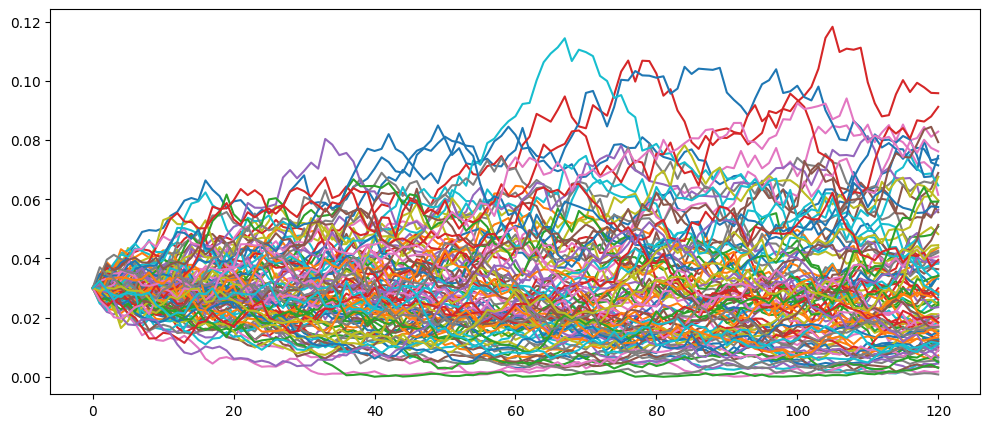

In [15]:
cir(n_scenarios = 100).plot(legend = False, figsize = (12, 5))

##### Generating the Random Price Evolution of a Zero-Coupon Bond
The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the follwing equations:
$$ p(t, T) = A(t, T)\cdot\exp(-B(t, T)r_t) $$
Where
$$ A(t, T) =  A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$

In [49]:
rates, prices = prt.cir_zero_coupon_bond(n_scenarios = 10)

<Axes: >

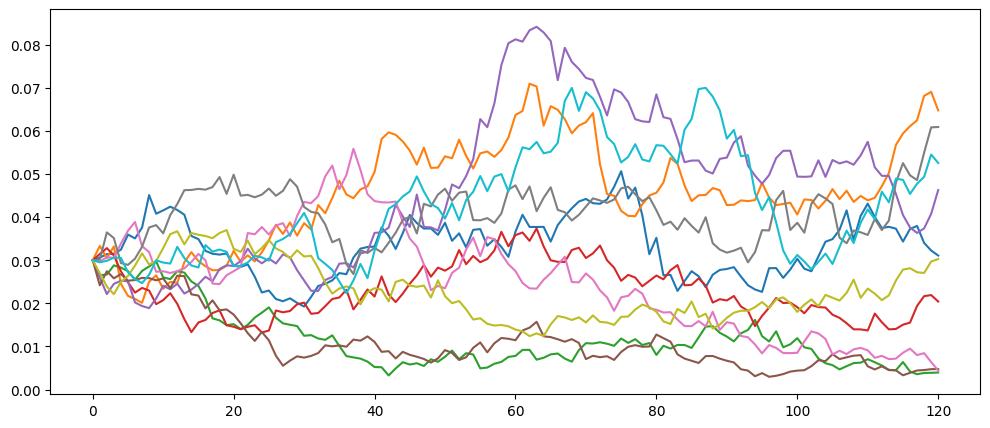

In [52]:
rates.plot(legend=False, figsize=(12, 5))

<Axes: >

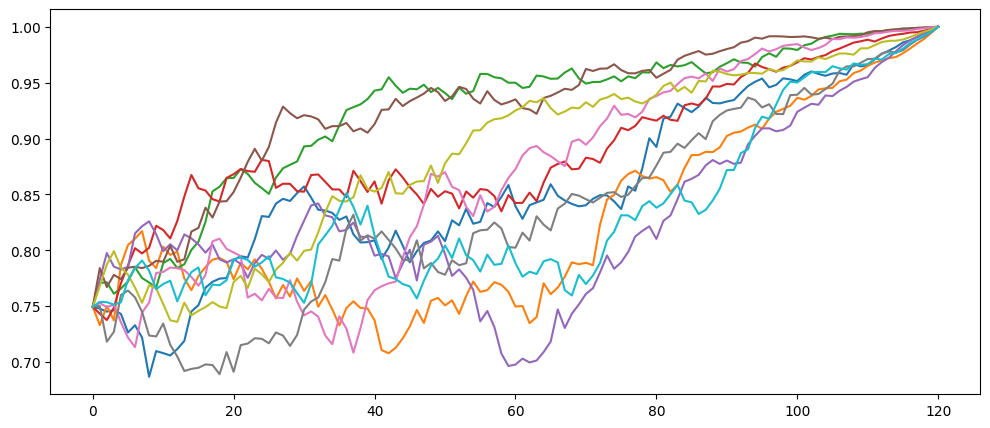

In [53]:
prices.plot(legend = False, figsize=(12, 5))

Now that we can generate randomly evolving interest rates and bond prices we can add the new code for `cir` to the toolkit.

Assume our liabilities are to pay one dollar in 10 years time. Clearly, the liability is perfectly matched by the price of zero coupon bond that matrues in 10 years. Therefore, this is perfectly matched by buying a zero coupon bond.

In [62]:
# starting asset value today
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = prt.cir_zero_coupon_bond(
    r_0 = 0.03,
    b = 0.03,
    n_scenarios = 10
)
# liabilities are going to change over time to match the payoff the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = prt.pv(pd.Series(data=[1], index=[10]), 0.03)
# We can put my money in a zero coupon bond at today's price
n_bonds = a_0 / zc_0
# and our asset value will grwo based on the bond prices.
av_zc_bonds = n_bonds * bond_prices
# how about if we invest in cash? It will grow at some rate of interest
av_cash = a_0 * (rates / 12 + 1).cumprod()

<Axes: >

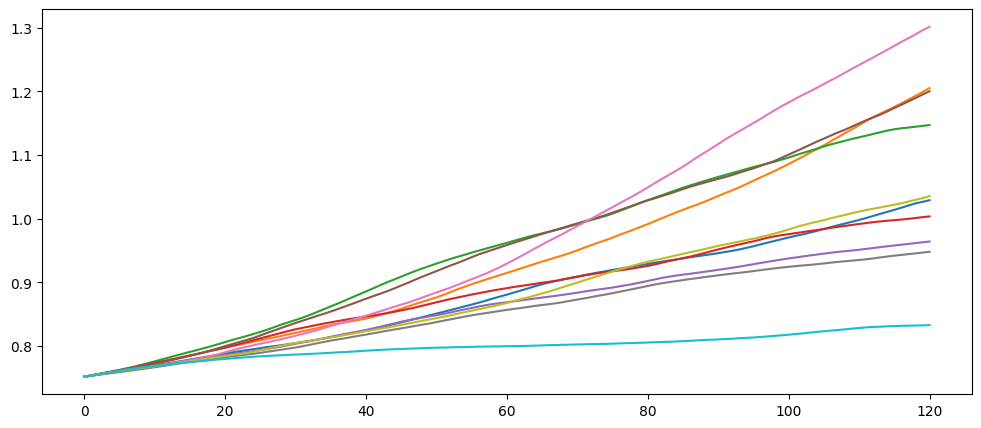

In [63]:
# Asset Value using Cash (10 Scenarios)
av_cash.plot(legend = False, figsize = (12, 5))

<Axes: >

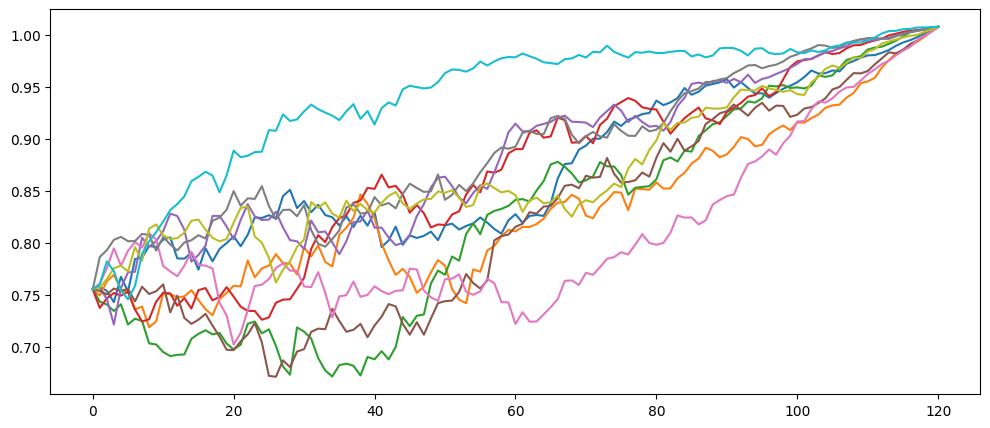

In [64]:
av_zc_bonds.plot(legend = False, figsize = (12, 5))

<Axes: >

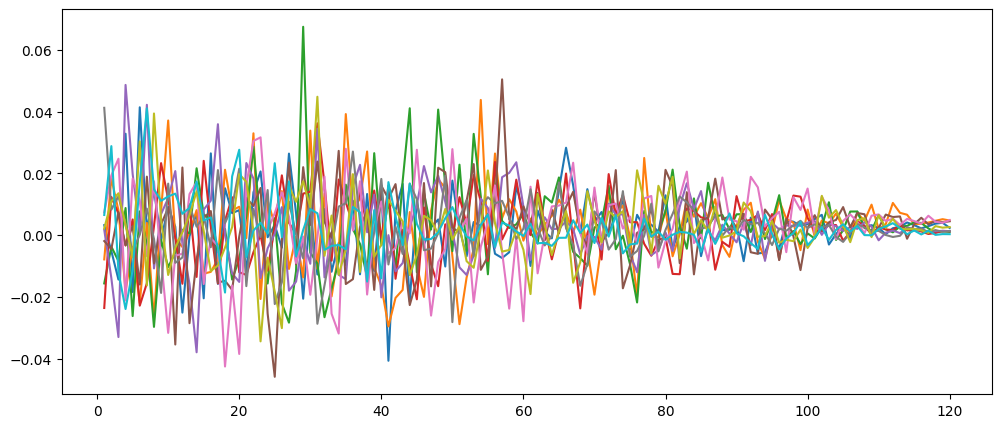

In [66]:
# Returns using ZC bonds (10 Scenarios)
av_zc_bonds.pct_change().plot(legend = False, figsize = (12, 5))

<Axes: >

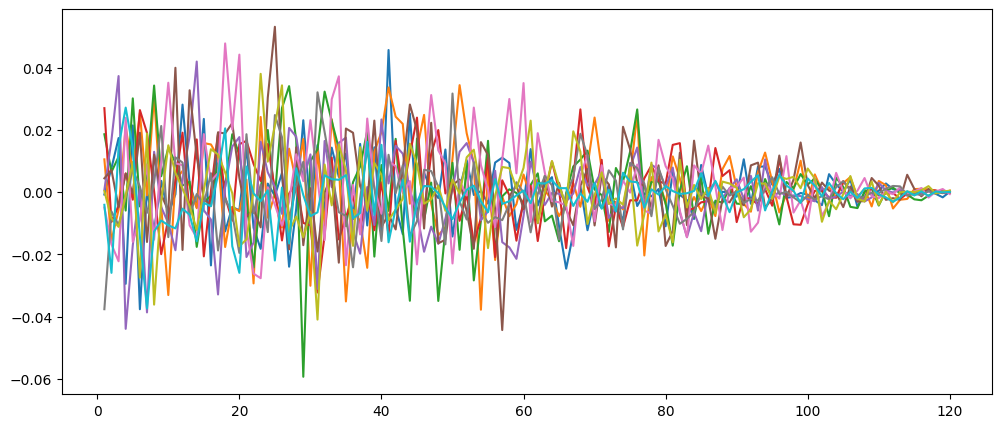

In [67]:
# Returns of Funding Ratio with Cash
(av_cash / liabilities).pct_change().plot(legend = False, figsize = (12, 5))

##### Terminal Funding Ratios
We can look at this in terms of Terminal Funding Ratios. Let's repeat this with a large number of simulations.

In [69]:
# our starting assets value today
a_0 = 0.75

# simulate the next 10 oyears
rates, bond_prices = prt.cir_zero_coupon_bond(
    r_0 = 0.03,
    b = 0.03,
    n_scenarios = 100000
)

# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices

# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = prt.pv(pd.Series(data = [1], index = [10]), 0.03)

# We can put our money in a zero coupon bond at today's price
n_bonds = a_0 / zc_0

# and our asset value will grwo based on the bond prices
av_zc_bonds = n_bonds * bond_prices

# cash
av_cash = a_0 * (rates / 12 + 1).cumprod()

<Axes: >

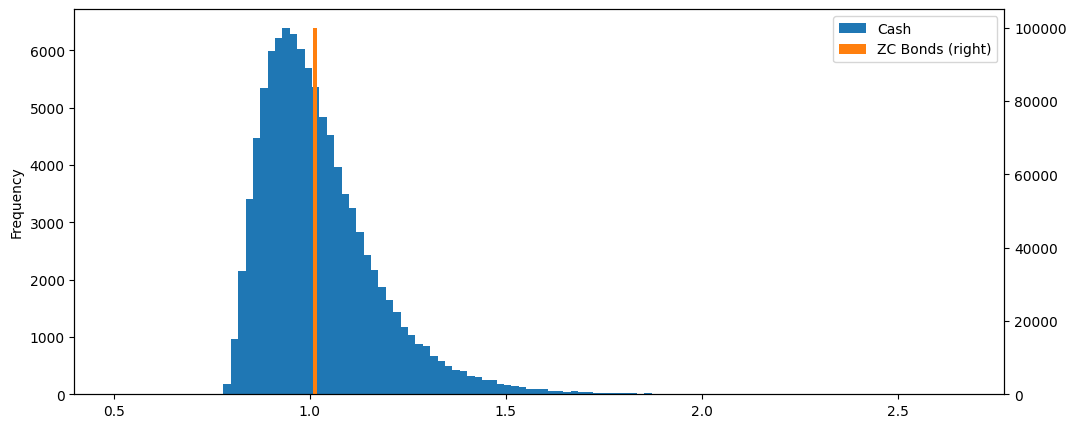

In [71]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label = "Cash", figsize = (12, 5), bins = 100, legend = True)
tfr_zc_bonds.plot.hist(ax = ax, label = "ZC Bonds", bins = 100, secondary_y = True, legend = True)

##### Conclusion
As we can see, hedging a future liability with cash or even cash-like instruments can be very risky. ALthough Zero Coupon Bonds are nominally risky and can see a great deal of price fluctuation, they vary in price in tandem with the liabilities, resulting in a much better hedge.

Of course, this makes convenient assumptions that are often not true in practice. First, it assumes that zero coupon bonds with the perfect maturities are always available, and second, it assumes that you have the initial assets to be able to afford the hedge.

We shall try and address these in future sections. We address the first by holding a portfolio of non-zero coupon bonds tha will behave like a zero-coupon bond in the sense that it can be liquidated at a particular maturity for an amount that is immunized against changes in interest rates. We well address the second issue by introducing a second building block to deliver the higher performance to try and close the gap between the current assets and the upside target.